In [1]:
%matplotlib notebook

import numpy as np
import json
from agent import Agent
from logic import Game
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/brockrx/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/brockrx/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/brockrx/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/brockrx/anaconda3/lib/python3.5/site-packages/t

In [2]:
def run_episode(game, agent):

    done = False
    S = []
    A = []
    R = []

    game.reset()
    
    s = game.get_state()

    total_reward = 0
    
    previous_highest_tile = game.highest_tile()
    
    exploitation = 1-agent.cross_game_exploration
    decay_factor = 1-agent.in_game_exploitation_decay-0.001
    
    board_list = []
    move_list = []

    while not done:
        
        board_list.append(game.board_list())
        
        a = agent.get_action(s, exploitation=1-exploitation)
        
        invalid_moves = []

        while not game.check_valid_move(a):

            total_reward -= agent.invalid_move_penalty

            S.append(s)
            A.append(a)
            R.append(agent.invalid_move_penalty)
            
            invalid_moves.append(a)
            
            a = agent.get_action(s, invalid_moves=invalid_moves, exploitation=1-exploitation)

        _, _, done, info = game.step(a)
        
        r = (game.highest_tile()>previous_highest_tile)*np.log2(game.highest_tile())
        s2 = game.get_state()
        
        move_list.append(int(a))
        
        highest_tile = game.highest_tile()
        total_reward += r

        if done:
            
            total_reward -= agent.loss_penalty

            S.append(s)
            A.append(a)
            R.append(agent.loss_penalty)
            
            S = np.array(S)
            A = np.array(A)
            R = np.array(R)

            agent.fit(S, A, R)
            score = game.score
            tile = game.highest_tile()
            
        else:
            S.append(s)
            A.append(a)
            R.append(r)
            
            previous_highest_tile = game.highest_tile()
            
            exploitation *= decay_factor
            
        s = s2

    return total_reward, score, tile, board_list, move_list

In [3]:
def main(episodes, agent_dic):

    game = Game()
    input_dim = game.get_state().shape
    
    output_dim = 4
    agent = Agent(input_dim,
                  output_dim,
                  conv_hidden_dims=agent_dic['conv_hidden_dims'],
                  loss_penalty=agent_dic['loss_penalty'],
                  invalid_move_penalty=agent_dic['invalid_move_penalty'],
                  discount_rate=agent_dic['discount_rate'])
    
    rewards = []
    scores = []
    tiles = []
    episode_list = []
    tile_list = [32, 64, 128, 256, 512, 1024, 2048]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ylim(0,1)
    ax.legend()
    
    fig.show()
    fig.canvas.draw()
    
    fig_r = plt.figure()
    ax_r = fig_r.add_subplot(111)
    plt.ion()
    
    fig_r.show()
    fig_r.canvas.draw()
    
    fig_s = plt.figure()
    ax_s = fig_s.add_subplot(111)
    plt.ion()
    
    fig_s.show()
    fig_s.canvas.draw()
    
    tile_plot = {}
    for tile in tile_list:
        tile_plot[tile] = []
        
    reward_plot = []
    
    score_plot = []
    
    save_dic = {}
    save_dic['agent'] = agent_dic
    save_start_index = 0
    
    for episode in range(episodes):

        reward, score, tile, board_list, move_list = run_episode(game, agent)
        
        agent.cross_game_exploration *= agent.cross_game_exploration_decay
        agent.in_game_exploitation_decay = agent.in_game_exploitation_decay_across_games*agent.in_game_exploitation_decay

        rewards.append(reward)
        scores.append(score)
        tiles.append(tile)
        episode_list.append(episode)
        
        start_index = (0>episode-500)*(0) + (1-(0>episode-500))*(episode-500)
        temp = tiles[start_index:]
        tile_frame = [tile for tile in temp]
        ax.clear()
        for t in tile_list:
            tile_plot[t].append(tile_frame.count(t)/len(tile_frame))
            ax.plot(tile_plot[t], label=str(t))
        ax.legend(loc='upper left')
        fig.canvas.draw()    
            
            
        temp = rewards[start_index:]
        reward_frame = np.array([reward for reward in temp])
        ax_r.clear()
        reward_plot.append(np.sum(reward_frame)/reward_frame.shape[0])
        ax_r.plot(reward_plot, label='Reward')
        ax_r.legend(loc='upper left')
        fig_r.canvas.draw()
        
        temp = scores[start_index:]
        score_frame = np.array([score for score in temp])
        ax_s.clear()
        score_plot.append(np.sum(score_frame)/score_frame.shape[0])
        ax_s.plot(score_plot, label='Score')
        ax_s.legend(loc='upper left')
        fig_s.canvas.draw()
        
        save_dic[int(episode)] = {
            'board': board_list,
            'move': move_list,
            'tile': tile,
            'score': score,
            'reward': reward}
        
        if (episode+1)%100 == 0:
            with open('game_history.csv', 'w') as file:
                json.dump(save_dic, file)
                
    agent.model.save('model.h5')
    
    return (agent, rewards, scores, tiles)

Agent 0 of 1.
Convolusional_dims: [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
Dicount rate: 0.995
Loss penalty: 64
Invalid move penalty: 0


<IPython.core.display.Javascript object>


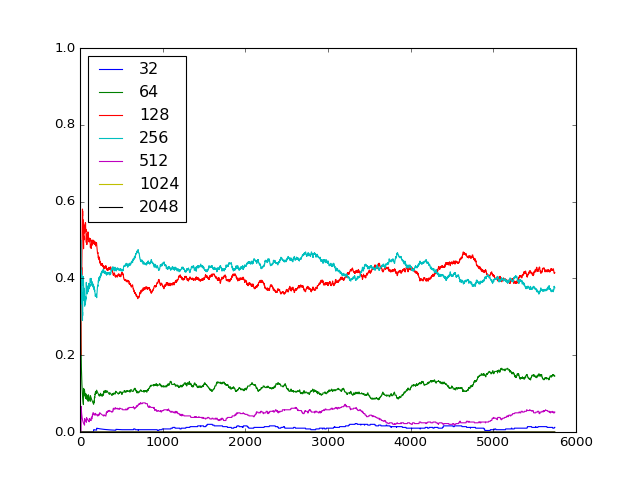

/home/brockrx/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<IPython.core.display.Javascript object>


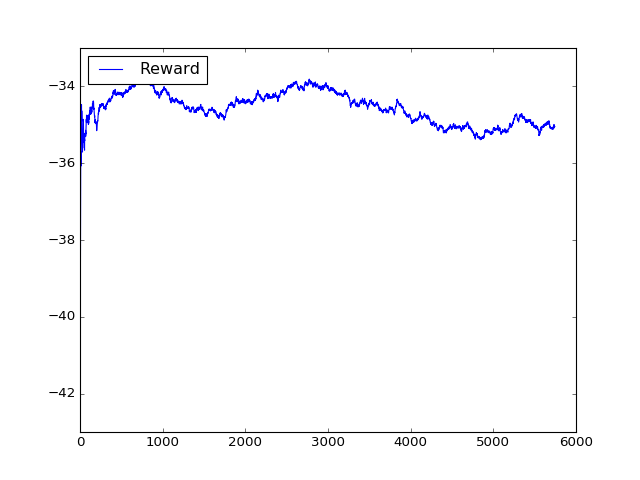

<IPython.core.display.Javascript object>


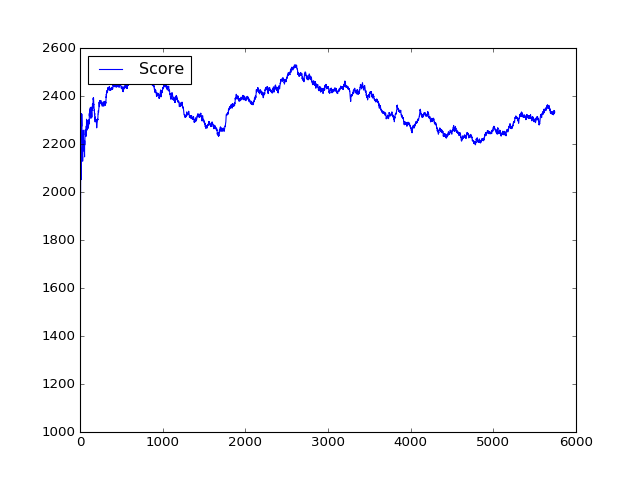

KeyboardInterrupt: 

In [4]:
param_dic = {}
param_dic['invalid_move_penalty'] = [0]
param_dic['loss_penalty'] = [64]
param_dic['discount_rate'] = [0.995]
param_dic['conv_hidden_dims'] = [[256 for x in range(16)]]
return_dic = {}
return_list = ['agent', 'rewards', 'scores', 'tiles']
for item in return_list:
    return_dic[item] = []

agents = int(np.prod(np.array([len(param_dic[key]) for key in list(param_dic.keys())])))
agent_number = 0
for dims in param_dic['conv_hidden_dims']:
    for discount_rate in param_dic['discount_rate']:
        for loss_penalty in param_dic['loss_penalty']:
            for invalid_move_penalty in param_dic['invalid_move_penalty']:
                agent_dic = {
                    'invalid_move_penalty': invalid_move_penalty,
                    'loss_penalty': loss_penalty,
                    'discount_rate': discount_rate,
                    'conv_hidden_dims': dims
                }
                print('Agent ' + str(agent_number) + ' of ' + str(agents) + '.')
                print('Convolusional_dims: ' + str(dims))
                print('Dicount rate: ' + str(discount_rate))
                print('Loss penalty: ' + str(loss_penalty))
                print('Invalid move penalty: ' + str(invalid_move_penalty))
                return_tuple = main(100000, agent_dic)
                for value, key in zip(return_tuple, list(return_dic.keys())):
                    return_dic[key].append(value)
                agent_number += 1

In [ ]:
model.save('model.h5')